In [1]:
#| default_exp models.dilated_rnn

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# Dilated RNN

The Dilated Recurrent Neural Network (`DilatedRNN`) addresses common challenges of modeling long sequences like vanishing gradients, computational efficiency, and improved model flexibility to model complex relationships while maintaining its parsimony. The `DilatedRNN` builds a deep stack of RNN layers using skip conditions on the temporal and the network's depth dimensions. The temporal dilated recurrent skip connections offer the capability to focus on multi-resolution inputs.The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{DilatedRNN}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\ 
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

where $\mathbf{h}_{t}$, is the hidden state for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

**References**<br>-[Shiyu Chang, et al. "Dilated Recurrent Neural Networks".](https://arxiv.org/abs/1710.02224)<br>-[Yao Qin, et al. "A Dual-Stage Attention-Based recurrent neural network for time series prediction".](https://arxiv.org/abs/1704.02971)<br>-[Kashif Rasul, et al. "Zalando Research: PyTorch Dilated Recurrent Neural Networks".](https://arxiv.org/abs/1710.02224)<br>

![Figure 1. Three layer DilatedRNN with dilation 1, 2, 4.](imgs_models/dilated_rnn.png)

In [3]:
#| hide
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [4]:
#| export
from typing import List

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_recurrent import BaseRecurrent
from neuralforecast.common._modules import MLP

In [5]:
#| exporti
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)
        gates = (torch.matmul(inputs, self.weight_ih.t()) + self.bias_ih +
                         torch.matmul(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)

In [6]:
#| exporti
class ResLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.register_buffer('input_size', torch.Tensor([input_size]))
        self.register_buffer('hidden_size', torch.Tensor([hidden_size]))
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)

        ifo_gates = (torch.matmul(inputs, self.weight_ii.t()) + self.bias_ii +
                                  torch.matmul(hx, self.weight_ih.t()) + self.bias_ih +
                                  torch.matmul(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)

        cellgate = torch.matmul(hx, self.weight_hh.t()) + self.bias_hh

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
            hy = outgate * (ry + inputs)
        else:
            hy = outgate * (ry + torch.matmul(inputs, self.weight_ir.t()))
        return hy, (hy, cy)

In [7]:
#| exporti
class ResLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        outputs = []
        for i in range(len(inputs)):
                out, hidden = self.cell(inputs[i], hidden)
                outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

In [8]:
#| exporti
class AttentiveLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super(AttentiveLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        attention_hsize = hidden_size
        self.attention_hsize = attention_hsize

        self.cell = LSTMCell(input_size, hidden_size)
        self.attn_layer = nn.Sequential(nn.Linear(2 * hidden_size + input_size, attention_hsize),
                                        nn.Tanh(),
                                        nn.Linear(attention_hsize, 1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = dropout

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        outputs = []

        for t in range(len(inputs)):
            # attention on windows
            hx, cx = (tensor.squeeze(0) for tensor in hidden)
            hx_rep = hx.repeat(len(inputs), 1, 1)
            cx_rep = cx.repeat(len(inputs), 1, 1)
            x = torch.cat((inputs, hx_rep, cx_rep), dim=-1)
            l = self.attn_layer(x)
            beta = self.softmax(l)
            context = torch.bmm(beta.permute(1, 2, 0),
                                inputs.permute(1, 0, 2)).squeeze(1)
            out, hidden = self.cell(context, hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

In [9]:
#| exporti
class DRNN(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dilations, dropout=0, cell_type='GRU', batch_first=True):
        super(DRNN, self).__init__()

        self.dilations = dilations
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        elif self.cell_type == "ResLSTM":
            cell = ResLSTMLayer
        elif self.cell_type == "AttentiveLSTM":
            cell = AttentiveLSTMLayer
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hidden, dropout=dropout)
            else:
                c = cell(n_hidden, n_hidden, dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])

            outputs.append(inputs[-dilation:])

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, dilated_steps = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size,
                                                       hidden=hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)

        return outputs, hidden

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            hidden = torch.zeros(batch_size * rate, hidden_size,
                                 dtype=dilated_inputs.dtype,
                                 device=dilated_inputs.device)
            hidden = hidden.unsqueeze(0)
            
            if self.cell_type in ['LSTM', 'ResLSTM', 'AttentiveLSTM']:
                hidden = (hidden, hidden)
                
        dilated_outputs, hidden = cell(dilated_inputs, hidden) # compatibility hack

        return dilated_outputs, hidden

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]

        interleaved = torch.stack((blocks)).transpose(1, 0).contiguous()
        interleaved = interleaved.view(dilated_outputs.size(0) * rate,
                                       batchsize,
                                       dilated_outputs.size(2))
        return interleaved

    def _pad_inputs(self, inputs, n_steps, rate):
        iseven = (n_steps % rate) == 0

        if not iseven:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0),
                                 inputs.size(1),
                                 inputs.size(2), 
                                 dtype=inputs.dtype,
                                 device=inputs.device)
            inputs = torch.cat((inputs, zeros_))
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

In [10]:
#| export
class DilatedRNN(BaseRecurrent):
    """ DilatedRNN

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `cell_type`: str, type of RNN cell to use. Options: 'GRU', 'RNN', 'LSTM', 'ResLSTM', 'AttentiveLSTM'.<br>
    `dilations`: int list, dilations betweem layers.<br>
    `encoder_hidden_size`: int=200, units for the RNN's hidden state size.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `learning_rate`: float=1e-3, initial optimization learning rate (0,1).<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 cell_type: str = 'LSTM',
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 encoder_hidden_size: int = 200,
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss=MAE(),
                 learning_rate: float = 1e-3,
                 batch_size=32,
                 step_size: int = 1,
                 scaler_type: str='robust',
                 random_seed=1,
                 num_workers_loader=0,
                 drop_last_loader=False,
                 **trainer_kwargs):
        super(DilatedRNN, self).__init__(
            h = h,
            input_size = input_size,
            loss=loss,
            learning_rate = learning_rate,
            batch_size=batch_size,
            scaler_type=scaler_type,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            **trainer_kwargs
        )

        # Dilated RNN
        self.cell_type = cell_type
        self.dilations = dilations
        self.encoder_hidden_size = encoder_hidden_size
        
        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)
        
        # RNN input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size

        # Instantiate model
        layers = []
        for grp_num in range(len(self.dilations)):
            if grp_num == 0:
                input_encoder = 1 + self.hist_exog_size + self.stat_exog_size
            else:
                input_encoder = self.encoder_hidden_size
            layer = DRNN(input_encoder,
                         self.encoder_hidden_size,
                         n_layers=len(self.dilations[grp_num]),
                         dilations=self.dilations[grp_num],
                         cell_type=self.cell_type)
            layers.append(layer)

        self.rnn_stack = nn.Sequential(*layers)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size + self.futr_exog_size * h,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # Concatenate y, historic and static inputs
        # [B, C, seq_len, 1] -> [B, seq_len, C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | S ]
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1,3).squeeze(-1) # [B, X, seq_len, 1] -> [B, seq_len, X]
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1) # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # DilatedRNN forward
        for layer_num in range(len(self.rnn_stack)):
            residual = encoder_input
            output, _ = self.rnn_stack[layer_num](encoder_input)
            if layer_num > 0:
                output += residual
            encoder_input = output

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,3,1)[:,:,1:,:]  # [B, F, seq_len, 1+H] -> [B, seq_len, H, F]
            encoder_input = torch.cat(( encoder_input, futr_exog.reshape(batch_size, seq_len, -1)), dim=2)

        # Context adapter
        context = self.context_adapter(encoder_input)
        context = context.reshape(batch_size, seq_len, self.h, self.context_size)

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)

        # Final forecast
        output = self.mlp_decoder(context)
        output = self.loss.domain_map(output)
        
        return output

## Usage Example

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

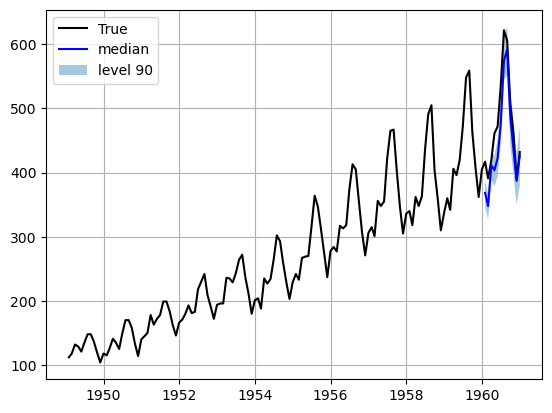

In [11]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[DilatedRNN(h=12, input_size=-1,
                       #loss=MAE(),
                       #loss=MQLoss(level=[80, 90]),
                       loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                       scaler_type='robust',
                       encoder_hidden_size=100,
                       max_epochs=200,
                       futr_exog_list=['y_[lag12]'],
                       hist_exog_list=None,
                       stat_exog_list=['airline1'],
    )
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
try:
    plt.plot(plot_df['ds'], plot_df['DilatedRNN-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'], 
                     y1=plot_df['DilatedRNN-lo-90.0'], y2=plot_df['DilatedRNN-hi-90.0'],
                     alpha=0.4, label='level 90')
except:
    plt.plot(plot_df['ds'], plot_df['DilatedRNN'], c='blue', label='median')
plt.legend()
plt.grid()
plt.plot()